# LeNet-5 (1998) – NumPy Implementation from Scratch

In this notebook I build LeNet-5, the CNN introduced by
Yann LeCun for handwritten digit recognition.

* **Dataset** : MNIST (60 k train / 10 k test)  
* **Input size** : LeNet expects 32 × 32 greyscale images.  
  MNIST is 28 × 28, so we pad 2 pixels on each side in the first
  convolution layer.


## Network Architecture

| Layer      | Type                 | Parameters                             | Output Shape (input 28x28) |
| ---------- | -------------------- | -------------------------------------- | -------------------------- |
| **C1**     | Convolution          | 6 filters, 5×5 kernel, stride=1, pad=2 | (6, 28, 28)                |
|            | Activation (Sigmoid) |                                        | (6, 28, 28)                |
| **S2**     | Average Pooling      | 2×2 window, stride=2                   | (6, 14, 14)                |
| **C3**     | Convolution          | 16 filters, 5×5 kernel, stride=1       | (16, 10, 10)               |
|            | Activation (Sigmoid) |                                        | (16, 10, 10)               |
| **S4**     | Average Pooling      | 2×2 window, stride=2                   | (16, 5, 5)                 |
| **C5**     | Convolution          | 120 filters, 5×5 kernel, stride=1      | (120, 1, 1)                |
|            | Activation (Sigmoid) |                                        | (120,)                     |
| **F6**     | Fully Connected      | 120 → 84                               | (84,)                      |
|            | Activation (Sigmoid) |                                        | (84,)                      |
| **Output** | Fully Connected      | 84 → 10                                | (10,)                      |

![Architecture](figures/Architecture.png)

Image source: Zhang, Aston and Lipton, Zachary C. and Li, Mu and Smola, Alexander J. - https://github.com/d2l-ai/d2l-en

## 1  Load and preprocess MNIST
Load the MNIST dataset from sklearn, normalize it to [0,1], and reshape for convolution layers.


In [4]:
import numpy as np
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1, as_frame=False)

X = mnist['data']       # Shape: (70000, 784)
y = mnist['target']     # Shape: (70000,)

X = X / 255.0           # Normalize pixel values to [0, 1]
y = y.astype(np.int32)  # Convert labels to integers

X = X.reshape(-1, 1, 28, 28) # Reshape for CNN

In [5]:
# Split into train/test (60k train, 10k test)
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (60000, 1, 28, 28)
X_test shape: (10000, 1, 28, 28)
y_train shape: (60000,)
y_test shape: (10000,)


## 2  Utility functions
Activation, loss, and padding. Documentation is generated by ChatGPT 4o.

In [6]:
def sigmoid(x):
    """
    Element-wise Sigmoid activation function.
    """
    return 1 / (1 + np.exp(-x))

def sigmoid_deriv(x):
    """
    Derivative of the sigmoid function.
    Used for backpropagation.
    """
    s = sigmoid(x)
    return s * (1 - s)

def softmax(Z: np.ndarray) -> np.ndarray:
    """
    Compute softmax probabilities over classes.

    Parameters:
    - Z: logits of shape (batch_size, num_classes)

    Returns:
    - softmax probabilities (batch_size, num_classes)
    """
    Z = Z - np.max(Z, axis=1, keepdims=True)
    exp_Z = np.exp(Z)
    return exp_Z / np.sum(exp_Z, axis=1, keepdims=True)

def CrossEntropy(yhat: np.ndarray, y: np.ndarray, eps: float = 1e-15) -> float:
    """
    Mean cross-entropy loss for multi-class classification.

    Parameters:
    - yhat: Predicted probabilities (batch_size, num_classes)
    - y: One-hot encoded true labels (batch_size, num_classes)
    - eps: Small epsilon to avoid log(0)

    Returns:
    - Mean cross-entropy loss over the batch
    """
    yhat = np.clip(yhat, eps, 1 - eps)
    return -np.mean(np.sum(y * np.log(yhat), axis=1))


## Zero Padding

Pad the input to get the 32×32 images LeNet-5 was designed for.  
This function does zero-padding around the spatial dimensions.


In [7]:
def padding(X: np.ndarray, p: int) -> np.ndarray:
    """
    Pads images with zeros.

    Parameters:
    - X: Input tensor of shape (batch, channels, height, width)
    - p: Padding size

    Returns:
    - Zero-padded tensor of shape (batch, channels, height + 2*p, width + 2*p)
    """
    batch, channel, height, width = X.shape
    Y = np.zeros((batch, channel, height + 2*p, width + 2*p))
    Y[:, :, p:p+height, p:p+width] = X
    return Y

## Convolution Layer (Forward)

This function performs a multi-channel, multi-filter convolution, padding inputs as needed.
We implement the forward pass using for loops, summing over input channels and applying each filter.


In [ ]:
def Convolution(X, p, in_channels, out_channels, K, bias):
    """
    Performs a convolution over multi-channel input with multiple output channels.
    
    Arguments:
    - X: input tensor of shape (batch, in_channels, height, width)
    - padding: number of padding pixels on each side
    - in_channels: number of input channels
    - out_channels: number of output channels (number of filters)
    - K: Kernel
    - bias: Bias term added to each output channel
    
    Returns:
    - Y: output tensor of shape (batch, out_channels, output_height, output_width)
    - K: The kernel to be reused
    - b: The bias to be reused
    """

    # Pad input
    if p > 0:
        X = padding(X, p)

    batch, channel, height, width = X.shape

    # Compute output size (assuming stride=1)
    output_height = height - K.shape[2] + 1
    output_width  = width - K.shape[3] + 1
    Y = np.zeros(shape=(batch, out_channels, output_height, output_width))

    """
    First attempt. Worked but was really slow. Kept here to showcase my struggles.

    for b in range(batch):
        for out_ch in range(out_channels):
            for in_ch in range(in_channels):
                for h in range(output_height):
                    for w in range(output_width):
                        Y[b, out_ch, h, w] += np.sum(
                            X[b, in_ch, h: h + K.shape[2], w: w + K.shape[3]] * 
                            K[out_ch, in_ch]
            Y[b, out_ch, :, :] += bias[out_ch]
    """
    # Vectorized height and width loop.-
    for b in range(batch):
        for out_ch in range(out_channels):
            accum = np.zeros((output_height, output_width))
            # Sum over each input channel
            for in_ch in range(in_channels):
                # This uses a 2D sliding window, no inner h,w loop
                for i in range(K.shape[2]):
                    for j in range(K.shape[3]):
                        accum += X[b, in_ch, i:i+output_height, j:j+output_width] * K[out_ch, in_ch, i, j]
            # Add bias
            Y[b, out_ch] = accum + bias[out_ch]

    return Y, K, bias

## Convolution Backward Pass

Computes gradients for weights, biases, and inputs.
This is a direct implementation of the chain rule for convolution layers. This was by far the most difficult part of the project and many errors appeared.


In [ ]:
def ConvBackward(dY, X, K):
    """
    Backpropagation for a convolution layer.

    Computes gradients w.r.t.:
    - input X
    - kernel weights K
    - bias

    Parameters:
    - dY: Gradient of loss w.r.t. output, shape (batch, out_channels, out_height, out_width)
    - X: Input to the convolution, shape (batch, in_channels, height, width)
    - K: Kernels, shape (out_channels, in_channels, kH, kW)

    Returns:
    - dX: Gradient w.r.t. input X
    - dK: Gradient w.r.t. kernels
    - db: Gradient w.r.t. biases (averaged over batch)
    """
    batch, in_channels, height, width = X.shape
    out_channels, _, kH, kW = K.shape
    out_height, out_width = dY.shape[2], dY.shape[3]

    dK = np.zeros_like(K)
    db = np.sum(dY, axis=(0,2,3)) / batch
    dX = np.zeros_like(X)

    for b in range(batch):
        for out_ch in range(out_channels):
            for in_ch in range(in_channels):
                for i in range(kH):
                    for j in range(kW):
                        h_end = i + out_height
                        w_end = j + out_width
                        # clip if we overshoot the input dims
                        if h_end > height or w_end > width:
                            h_end = min(h_end, height)
                            w_end = min(w_end, width)
                            slice_h = h_end - i
                            slice_w = w_end - j
                            # also slice dY to match
                            dY_slice = dY[b, out_ch, :slice_h, :slice_w]
                            X_slice = X[b, in_ch, i:h_end, j:w_end]
                        else:
                            X_slice = X[b, in_ch, i:h_end, j:w_end]
                            dY_slice = dY[b, out_ch]

                        # Accumulate gradients for kernel weights
                        dK[out_ch, in_ch, i, j] += np.sum(X_slice * dY_slice) / batch

                         # Accumulate gradients for input
                        dX[b, in_ch, i:h_end, j:w_end] += K[out_ch, in_ch, i, j] * dY_slice
    return dX, dK, db

## Average Pooling Layer (Forward)

Implements average pooling with a specified kernel size and stride.
This uses a vectorized sliding window summation.


In [ ]:
def Pooling(X, kernel_size, stride):
    """
    Average pooling operation.

    Parameters:
    - X: Input tensor of shape (batch, channel, height, width)
    - kernel_size: Tuple (kH, kW) specifying pooling window size
    - stride: Stride of the pooling operation

    Returns:
    - Y: Output tensor after pooling
    """

    batch, channel, height, width = X.shape
    output_height = (height - kernel_size[0]) // stride + 1
    output_width  = (width - kernel_size[1]) // stride + 1
    Y = np.zeros(shape=(batch, channel, output_height, output_width))

    """
    First attempt, too slow.
    for b in range(batch):
        for ch in range(channel):
            for h in range(output_height):
                for w in range(output_width):
                    # Calculated this from a piece of paper, helped me understand everything a lot better.
                    Y[b, ch, h, w] = np.mean(X[b, ch, 
                                               (h * stride): (h * stride) + kernel_size[0],
                                               (w * stride): (w * stride) + kernel_size[1]])
    """

    window_sum = np.zeros((batch, channel, output_height, output_width))
    for i in range(kernel_size[0]):
        for j in range(kernel_size[1]):
            window_sum += X[:, :, i:i+output_height*stride:stride, j:j+output_width*stride:stride]
    Y = window_sum / (kernel_size[0] * kernel_size[1])

    return Y

## Average Pooling Backward Pass

Distributes gradients equally over the region covered by each pooling window.


In [ ]:
def PoolingBackward(dY, X, kernel_size, stride):
    """
    Backpropagation for average pooling.

    Spreads gradient uniformly over the region that was pooled.

    Parameters:
    - dY: Gradient w.r.t. output, shape (batch, channel, out_height, out_width)
    - X: Input to pooling layer, shape (batch, channel, height, width)
    - kernel_size: Tuple (kH, kW)
    - stride: Pooling stride

    Returns:
    - dX: Gradient w.r.t. input X
    """
    
    batch, channel, height, width = X.shape
    output_height, output_width = dY.shape[2], dY.shape[3]
    kH, kW = kernel_size
    dX = np.zeros_like(X)

    for b in range(batch):
        for ch in range(channel):
            for h in range(output_height):
                for w in range(output_width):
                    dX[b, ch,
                       (h * stride):(h * stride) + kH,
                       (w * stride):(w * stride) + kW] += dY[b, ch, h, w] / (kH * kW)
    return dX

# Xavier Initialization

We initialize all kernels (weights) with Xavier initialization, which sets weights in a range depending on the number of input and output connections. This helps maintain stable variance across layers.

We also initialize biases to zeros.


In [ ]:
def xavier_init(size, n_in, n_out):
    """
    Xavier (Glorot) initialization for weights.

    Parameters:
    - size: Shape of the weight tensor
    - n_in: Number of input units
    - n_out: Number of output units

    Returns:
    - np.ndarray: Initialized weights
    """
    
    limit = np.sqrt(6 / (n_in + n_out))
    return np.random.uniform(-limit, limit, size=size)

In [ ]:
# Xavier initialization for each layer

# C1: 6 filters, 1 input channel, 5x5 kernel
c1_kernel = xavier_init(size=(6, 1, 5, 5), n_in=25, n_out=150)
c1_bias = np.zeros(6)

# C3: 16 filters, 6 input channels
c3_kernel = xavier_init(size=(16, 6, 5, 5), n_in=150, n_out=400)
c3_bias = np.zeros(16)

# C5: 120 filters, 16 input channels
c5_kernel = xavier_init(size=(120, 16, 5, 5), n_in=400, n_out=3000)
c5_bias = np.zeros(120)

# F6: fully connected 120 -> 84
f6_weights = xavier_init((84, 120), n_in=120, n_out=84)
f6_bias = np.zeros(84)

# Output layer: fully connected 84 -> 10
out_weights = xavier_init((10, 84), n_in=84, n_out=10)
out_bias = np.zeros(10)

# Training Loop

Trains the network over multiple epochs. Uses SGD to update weights.
Includes explicit forward and backward passes through all layers.

We also shuffle the data each epoch to improve convergence.


In [ ]:
batch_size = 4
epochs = 8
lr = 0.01

for epoch in range(epochs):
    total_loss = 0    # Sum of losses for this epoch
    correct = 0       # Count of correct predictions

    # Shuffle data each epoch
    perm = np.random.permutation(X_train.shape[0])
    X_train = X_train[perm]
    y_train = y_train[perm]
    
    for batch in range(0, X_train.shape[0], 4):
        X_train_batch = X_train[batch: batch + batch_size]  # (batch_size, 784)
        y_train_batch = y_train[batch: batch + batch_size]  # (batch_size,)
        batch_len = X_train_batch.shape[0]  # Actual batch size (handles last batch)

        # Forward Pass
        c1, c1_kernel, c1_bias = Convolution(X_train_batch,
                                             p=2, 
                                             in_channels=1, 
                                             out_channels=6,
                                             K=c1_kernel,
                                             bias=c1_bias)
        a1 = sigmoid(c1)
        s2 = Pooling(a1, kernel_size=(2, 2), stride=2)
        c3, c3_kernel, c3_bias = Convolution(s2,
                                             p=0,
                                             in_channels=6,
                                             out_channels=16,
                                             K=c3_kernel,
                                             bias=c3_bias
                                             )
        a3 = sigmoid(c3)
        s4 = Pooling(a3, kernel_size=(2, 2), stride=2)
        c5, c5_kernel, c5_bias = Convolution(s4,
                                             p=0,
                                             in_channels=16,
                                             out_channels=120,
                                             K=c5_kernel,
                                             bias=c5_bias
                                             )
        a5 = sigmoid(c5).reshape(4, 120)
        f6 = np.dot(a5, f6_weights.T) + f6_bias
        a6 = sigmoid(f6)
        output = np.dot(a6, out_weights.T) + out_bias
        yhat = softmax(output)

        # Onehot Encoding Labels
        y_onehot = np.zeros((batch_len, 10))
        y_onehot[np.arange(batch_len), y_train_batch] = 1   # Turn class indices into one-hot vectors

        # Loss and Accuracy
        loss = CrossEntropy(yhat, y_onehot)                 # Average loss over batch
        total_loss += loss
        preds = np.argmax(yhat, axis=1)                     # Class prediction per sample
        correct += np.sum(preds == y_train_batch)           # Tally correct predictions

        dz_output = yhat - y_onehot
        # Grad for output layer
        dw_out = np.dot(dz_output.T, a6) / batch_len  # shape (10, 84)
        db_out = dz_output.sum(axis=0) / batch_len    # shape (10,)

        # Propagate to hidden layer
        da6 = np.dot(dz_output, out_weights)          # (batch, 84)
        dz6 = da6 * sigmoid_deriv(f6)                 # (batch, 84)

        # Grad for F6 layer
        dw_f6 = np.dot(dz6.T, a5) / batch_len         # shape (84, 120)
        db_f6 = dz6.sum(axis=0) / batch_len           # shape (84,)

        # Propagate to C5 output
        da5 = np.dot(dz6, f6_weights)                 # (batch, 120)
        da5 = da5.reshape(batch_len, 120, 1, 1)       # for compatibility with conv

        # Propagate through C5 layer
        ds4, dK5, db5 = ConvBackward(da5, s4, c5_kernel)

        # Propagate through S4
        da3 = PoolingBackward(ds4, a3, (2,2), 2)

        #Propagate through C3
        ds2, dK3, db3 = ConvBackward(da3 * sigmoid_deriv(c3), s2, c3_kernel)

        #Propagate through S2
        da1 = PoolingBackward(ds2, a1, (2,2), 2)

        #Propagate through C1
        _, dK1, db1 = ConvBackward(da1 * sigmoid_deriv(c1), X_train_batch, c1_kernel)

        # Adjusting Parameters
        out_weights -= lr * dw_out
        out_bias -= lr * db_out
        f6_weights -= lr * dw_f6
        f6_bias -= lr * db_f6
        c5_kernel -= lr * dK5
        c5_bias -= lr * db5
        c3_kernel -= lr * dK3
        c3_bias -= lr * db3
        c1_kernel -= lr * dK1
        c1_bias -= lr * db1

    # Epoch Results
    acc = correct / X_train.shape[0]
    print(f"Epoch {epoch+1} | Loss: {total_loss / X_train.shape[0]:.4f} | Accuracy: {acc:.4f}")
        

# LeNet-5 on MNIST with PyTorch

Running through this would take days on my laptop. Instead I am going to replicate the model in pytorch and train it on Kaggles GPU T4 x2

In [ ]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Normalize MNIST using the dataset's standard mean (0.1307) and std (0.3081).

In [ ]:
X = mnist['data']       # Shape: (70000, 784)
y = mnist['target']     # Shape: (70000,)

X = X / 255.0               # Normalize pixel values to [0, 1]
X = (X - 0.1307) / 0.3081   # Standardize

X = X.reshape(-1, 1, 28, 28) # Reshape for CNN

# Split into train/test (60k train, 10k test)
X_train, X_test = X[:60000], X[60000:]
y_train, y_test = y[:60000], y[60000:]

## PyTorch Tensors & DataLoaders
Convert data to torch tensors and wrap in DataLoader.

In [ ]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_dataloader = DataLoader(test_dataset, batch_size=4, shuffle=False)

## Define LeNet-5 Model

In [6]:
class LeNet5(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Sigmoid(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Sigmoid(),
            nn.Flatten(),
            nn.Linear(in_features=120, out_features=84),
            nn.Sigmoid(),
            nn.Linear(in_features=84, out_features=10)
        )
    def forward(self, x):
        return self.net(x)

In [ ]:
model = LeNet5()
# Apply Xavier initialization to Conv2d and Linear layers.
def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_uniform_(m.weight)
model.apply(init_weights)

# Use DataParallel for multi GPU support (Kaggles GPU T4 x2)
model = nn.DataParallel(model)
model = model.to(device)

optimizer = optim.SGD(model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

# Training loop
epochs = 10
for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    correct = 0
    total = 0
    
    for xb, yb in train_dataloader:
        xb, yb = xb.to(device), yb.to(device)
        
        optimizer.zero_grad()
        yhat = model(xb)
        loss = loss_fn(yhat, yb)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * xb.size(0)
        preds = torch.argmax(yhat, dim=1)
        correct += (preds == yb).sum().item()
        total += xb.size(0)

    avg_loss = total_loss / total
    accuracy = correct / total

    # Validation
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for xb, yb in test_dataloader:
            xb, yb = xb.to(device), yb.to(device)
            yhat = model(xb)
            loss = loss_fn(yhat, yb)
            val_loss += loss.item() * xb.size(0)
            preds = torch.argmax(yhat, dim=1)
            val_correct += (preds == yb).sum().item()
            val_total += xb.size(0)
    
    avg_val_loss = val_loss / val_total
    val_accuracy = val_correct / val_total

    print(f"Epoch {epoch+1}: "
          f"Train Loss: {avg_loss:.4f}, Train Acc: {accuracy:.4f}, "
          f"Val Loss: {avg_val_loss:.4f}, Val Acc: {val_accuracy:.4f}")

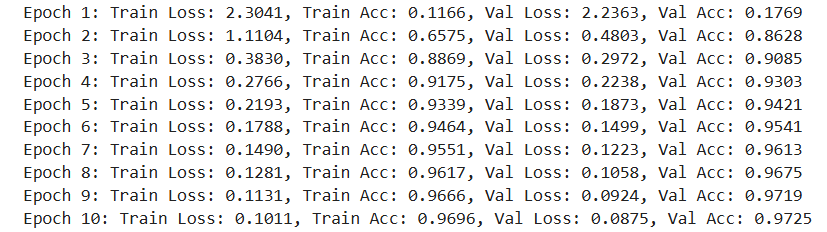

In [2]:
from IPython.display import Image
Image('figures/Results.png')

# Conclusion

In this project, I successfully implemented the classic LeNet-5 architecture both from scratch in NumPy (including manual forward and backward passes for convolutions, pooling, and fully connected layers) and then replicated it in PyTorch, using GPU acceleration for practical training.

I was disappointed that I couldn’t complete the training purely from scratch using my NumPy implementation on a laptop CPU. I added vectorization and after over 12 hours of runtime, not even a single epoch had completed. This is a clear demonstration of how slow manual loops are without optimizations like im2col.

This experience reinforced just how critical optimized libraries (like PyTorch or TensorFlow) are for deep learning. They hide these costly operations behind efficient CUDA kernels and parallelized CPU operations, enabling models like LeNet-5 to train in minutes rather than days.

Overall, despite the challenge of not being able to fully train my from-scratch model, this project gave me deep insights into the mathematical operations, data flows, and practical engineering trade-offs behind convolutional neural networks.